In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch
import torch.nn.functional as F
import torch.distributions.gamma
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import genextreme

In [2]:
class LinearNetwork(nn.Module):
    def __init__(self):
        super(LinearNetwork,self).__init__()
        self.fc1=nn.Linear(2,10)
        self.fc2=nn.Linear(10,312)

    def forward(self,x):
        x=self.fc1(x)
        x=self.fc2(x)
        return x

model=LinearNetwork()

In [3]:
class ANN(nn.Module):
    def __init__(self):
        super(ANN,self).__init__()
        self.fc1=nn.Linear(2,10)
        self.fc2=nn.Linear(10,100)
        self.fc3=nn.Linear(100,312)

    def forward(self,x):
        x=self.fc1(x)
        x=torch.relu(x)
        x=self.fc2(x)
        x=torch.relu(x)
        x=self.fc3(x)
        return x

model2=ANN()

In [32]:
class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size=2,padding=1)
        self.conv2 = nn.Conv2d(1, 312, kernel_size=2)
        self.bn1 = nn.BatchNorm2d(1)
        self.bn2 = nn.BatchNorm2d(312)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        return x

modelCNN=ConvNet2()

In [33]:
##Finalement on entraîne avec les maximas pas les params de GEV 

In [34]:
class CustomCRPSLoss(nn.Module):
    def __init__(self):
        super(CustomCRPSLoss, self).__init__()

    def forward(self, y_pred, y_true):
        term_one = torch.mean(torch.abs(y_pred - y_true), dim=-1)
        term_two = torch.mean(torch.abs(
        torch.unsqueeze(y_pred, -1) - torch.unsqueeze(y_pred, -2)), dim=(-2, -1))
        half = torch.tensor(-0.5, dtype=term_two.dtype)
        loss = term_one + half * term_two
        loss = torch.mean(loss)
        return loss

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model2 = model2.to(device)

In [36]:
path = "/work/FAC/FGSE/IDYST/tbeucler/downscaling/mberthier/repos/Downscaling_CM/data"
os.chdir(path)
train_data=xr.open_dataset('train_data_stationnary.nc')

In [37]:
num_weeks = len(train_data['week'])
print("Nombre de semaines :", num_weeks)

Nombre de semaines : 312


In [38]:
out_cnn.size()

torch.Size([101, 176, 312])

Epoch [10/10], Loss: 0.0320


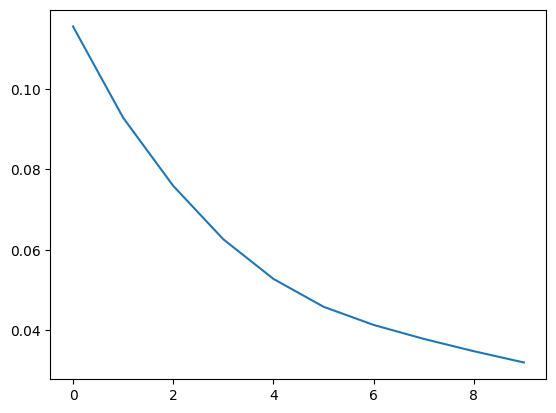

In [39]:
num_epoch=10
train_len=num_weeks
nb_lon= len(train_data['rlon'])
nb_lat= len(train_data['rlat'])

rlat = torch.tensor(train_data['rlat'].values)
rlon=torch.tensor(train_data['rlon'].values)
grid_lat, grid_lon = torch.meshgrid(rlat, rlon)
input = torch.stack((grid_lat, grid_lon), dim=-1)
batch_output=training_set_output(train_data)
optimizer1= torch.optim.Adam(model.parameters(), lr=0.01)
optimizer2= torch.optim.Adam(model2.parameters(), lr=0.01)
optimizer3=torch.optim.Adam(modelCNN.parameters(),lr=0.01)
loss_crps=CustomCRPSLoss()
loss_list1=[]
loss_list2=[]
loss_list3=[]

for epoch in range(num_epoch):
         #print('EPOCH : ',epoch)
        #print(list(model.parameters()))
        outputs_lnn=model(input)
        outputs_ann=model2(input)

        ##CNN : 
        input_prepared=input.unsqueeze(0)
        input_prepared=input_prepared.permute(0, 3, 1, 2)
        outputs_cnn=modelCNN(input_prepared)
        ##CNN Architecture (batch_size, channels, height, width)

        ##batch_output est de taille (height,width,channels)

        loss1=loss_crps(outputs_lnn,batch_output)
        loss1=torch.mean(loss1)
        #print(loss1)
    
        loss_list1.append(torch.detach(loss1).numpy())
        optimizer1.zero_grad()
        loss1.backward()
        optimizer1.step()

        loss2=loss_crps(outputs_ann,batch_output)
        loss_list2.append(torch.detach(loss2).numpy())
        optimizer2.zero_grad()
        loss2.backward()
        optimizer2.step()


        out_cnn = outputs_cnn.permute(2, 3, 1, 0)
        out_cnn = torch.flatten(out_cnn,start_dim=2)
    
        loss3=loss_crps(out_cnn,batch_output)
        loss_list3.append(torch.detach(loss3).numpy())
        optimizer3.zero_grad()
        loss3.backward()
        optimizer3.step()
    
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epoch}], Loss: {loss1.item():.4f}')
plt.plot(loss_list1)
#plt.plot(loss_list2,add=True)
plt.show()

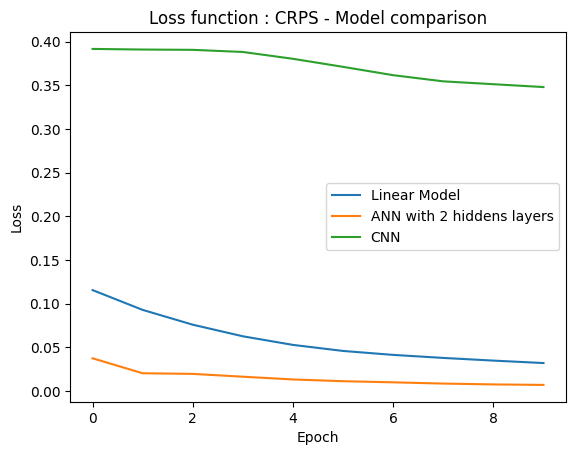

In [40]:
import matplotlib.pyplot as plt

# Tracer les données
plt.plot(loss_list1, label='Linear Model')
plt.plot(loss_list2, label='ANN with 2 hiddens layers')
plt.plot(loss_list3, label='CNN')

# Titres et légendes
plt.title('Loss function : CRPS - Model comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Afficher le graphique
plt.show()


In [ ]:
loss_list

In [56]:
input_test=torch.tensor([1.0,1.0])
output_test=model2(input_test)

In [57]:
output_test

tensor([nan, nan, nan], grad_fn=<AddBackward0>)

In [ ]:
##vérifier ! 